In [1]:
import torch
from torch.utils.data import Dataset, DataLoader 

class CustomDataset(Dataset):
    def __init__(self, text, labels):
        self.text = text 
        self.labels = labels 

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        sample = {"Text": text, "Class": label}
        return sample 

In [2]:
text = ['Happy', 'Amazing', 'Sad', 'Unhappy', 'Glum']
labels = ['Positive', 'Positive', 'Negative', 'Negative', 'Negative']
MyDataset = CustomDataset(text, labels)

In [3]:
MyDataLoader = DataLoader(MyDataset, batch_size=2, shuffle=True)
next(iter(MyDataLoader))

{'Text': ['Happy', 'Glum'], 'Class': ['Positive', 'Negative']}

In [4]:
MyDataLoader = DataLoader(MyDataset, batch_size=2, shuffle=True)

for dataset in MyDataLoader:
    print(dataset)

{'Text': ['Glum', 'Unhappy'], 'Class': ['Negative', 'Negative']}
{'Text': ['Amazing', 'Happy'], 'Class': ['Positive', 'Positive']}
{'Text': ['Sad'], 'Class': ['Negative']}


# Custom Dataset

In [5]:
from torchvision.datasets import VisionDataset
from typing import Any, Callable, Dict, List, Optional, Tuple 
import os

from tqdm import tqdm 
import os 
import sys 
from pathlib import Path 
import requests 

from skimage import io, transform 
import matplotlib.pyplot as plt 

In [110]:
import tarfile

class NotMNIST(VisionDataset):
    headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:55.0) Gecko/20100101 Firefox/55.0',
    }

    # http://yaroslavvb.com/upload/notMNIST/
    resource_url = 'http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz'

    def __init__(self, 
                root: str, 
                train: bool = True, 
                transform: Optional[Callable] = None, 
                target_transform: Optional[Callable] = None,
                download: bool = False
    ) -> None:
        super(NotMNIST, self).__init__(root, 
                                        transform=transform, 
                                        target_transform=target_transform)
        
        if not self._check_exists() and download: self.download()
        
        self.data, self.targets = self._load_data()


    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) :
        image_name = self.data[idx]
        image = io.imread(image_name)
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def _load_data(self):
        filepath = self.image_folder 
        data = list()
        targets = list()

        for target in os.listdir(filepath):
            if not os.path.isdir(os.path.join(filepath, target)): continue
            filename = [os.path.abspath(os.path.join(filepath, target, x)) 
                        for x in os.listdir(os.path.join(filepath, target))]
            targets.extend([target] * len(filename))
            data.extend(filename)
        
        print("data size is ",len(data))
        return data, targets

    @property 
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'raw') 

    @property 
    def image_folder(self) -> str:
        return os.path.join(self.root, 'notMNIST_large')

    def _urlretrieve(self, url: str, filename: str, chunk_size: int = 1024) -> None:
        ''' This is test code from the template '''
        USER_AGENT = "pytorch/vision"
        import urllib 

        with open(filename, "wb") as fh:
            with urllib.request.urlopen(urllib.request.Request(url, headers={"User-Agent": USER_AGENT})) as response:
                with tqdm(total=response.length) as pbar:
                    for chunk in iter(lambda: response.read(chunk_size), ""):
                        if not chunk:
                            break
                        pbar.update(chunk_size)
                        fh.write(chunk)

    def download(self) -> None:
        os.makedirs(self.raw_folder, exist_ok=True)
        fname = self.resource_url.split('/')[-1]
        chunk_size = 1024

        #self._urlretrieve(self.resource_url, fname, chunk_size=chunk_size)
        filesize = int(requests.head(self.resource_url,headers=self.headers).headers["Content-Length"])
        print(f"file name: {fname} - size: {filesize}")

        with open(os.path.join(self.raw_folder, fname), "wb") as f, requests.get(
            self.resource_url, stream=True, headers=self.headers) as r, tqdm (                                                   
            unit="B",                                           
            unit_scale=True,                                   
            unit_divisor=1024,                                  
            total=filesize,                                     
            file=sys.stdout,                                
            desc=fname                                          
        ) as progress:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if not chunk: break
                # download the file chunk by chunk
                datasize = f.write(chunk)
                # on each chunk update the progress bar.
                progress.update(datasize)

        self._extract_file(os.path.join(self.raw_folder, fname), target_path=self.root)

    def _extract_file(self, fname, target_path) -> None:
        if fname.endswith("tar.gz"):
            tag = "r:gz"
        elif fname.endswith("tar"):
            tag = "r:"
        
        tar = tarfile.open(fname, tag)
        tar.extractall(path=target_path)
        tar.close()

    def _check_exists(self) -> bool:
        return os.path.exists(self.raw_folder)


In [111]:
dataset = NotMNIST("data", download=True)

data size is  529119


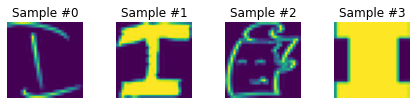

In [112]:
fig = plt.figure()

for i in range(8):
    sample = dataset[i]

    ax  = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0])

    if i == 3:
        plt.show()
        break

In [113]:
import torch 
from torchvision import transforms, datasets 
from torch.utils.data import DataLoader

data_transform = transforms.Compose([ 
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = NotMNIST("data", download=False)

data size is  529119


In [114]:

dataset_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [115]:
train_features, train_labels = next(iter(dataset_loader))

In [116]:
train_features.shape

torch.Size([128, 28, 28])

In [117]:
train_labels

('J',
 'I',
 'H',
 'B',
 'C',
 'G',
 'A',
 'I',
 'B',
 'G',
 'I',
 'A',
 'D',
 'J',
 'I',
 'J',
 'J',
 'J',
 'F',
 'F',
 'C',
 'G',
 'D',
 'H',
 'E',
 'D',
 'D',
 'E',
 'A',
 'J',
 'B',
 'C',
 'J',
 'E',
 'F',
 'B',
 'C',
 'I',
 'B',
 'A',
 'B',
 'G',
 'B',
 'E',
 'A',
 'E',
 'F',
 'E',
 'C',
 'C',
 'F',
 'J',
 'E',
 'J',
 'I',
 'I',
 'A',
 'G',
 'I',
 'I',
 'D',
 'E',
 'B',
 'J',
 'I',
 'E',
 'B',
 'D',
 'G',
 'G',
 'G',
 'G',
 'D',
 'F',
 'G',
 'I',
 'C',
 'I',
 'I',
 'C',
 'G',
 'J',
 'B',
 'B',
 'F',
 'J',
 'D',
 'C',
 'D',
 'E',
 'D',
 'C',
 'D',
 'I',
 'B',
 'J',
 'D',
 'G',
 'D',
 'G',
 'J',
 'B',
 'H',
 'E',
 'E',
 'D',
 'B',
 'H',
 'A',
 'E',
 'C',
 'A',
 'F',
 'A',
 'F',
 'C',
 'D',
 'F',
 'C',
 'I',
 'H',
 'J',
 'E',
 'D',
 'A',
 'E',
 'E',
 'F')